In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
import xarray as xr
xr.set_options(keep_attrs=True)

In [4]:
from ecephys_analyses import load as ld
from ecephys import xrsig

In [5]:
def ds2df(ds):
    s = ds.to_dataframe().drop(columns=['time', 'timedelta']).stack()
    s.index.names = s.index.names[:-1] + ['region']
    return s.to_frame(name='power')

In [20]:
subject = "Adrian"
ref_experiment = "novel_objects_deprivation"
ref_alias = "sleep_deprivation"
ref_condition_name = "NO"
rel_experiment = "conveyor_over_water"
rel_alias = "sleep_deprivation"
rel_condition_name = "COW"
probe = "imec1"
states = ["Wake"]
time_in_states = '06:00:00'

In [13]:
def smooth_spg(spg, smoothing_sigma):
    # width of the kernel is ~8x sigma. So sigma=1 -> ~8 frequency bins -> ~2Hz at 0.25Hz resolution. 
    df = spg.groupby(["frequency", "condition", "region"]).mean()
    df.loc[(slice(None), ref_condition_name, 'mpta_wm_ref'), :] = gaussian_filter(df.loc[(slice(None), ref_condition_name, 'mpta_wm_ref'), :], smoothing_sigma)
    df.loc[(slice(None), rel_condition_name, 'mpta_wm_ref'), :] = gaussian_filter(df.loc[(slice(None), rel_condition_name, 'mpta_wm_ref'), :], smoothing_sigma)
    df.loc[(slice(None), ref_condition_name, 'sr_wm_ref'), :] = gaussian_filter(df.loc[(slice(None), ref_condition_name, 'sr_wm_ref'), :], smoothing_sigma)
    df.loc[(slice(None), rel_condition_name, 'sr_wm_ref'), :] = gaussian_filter(df.loc[(slice(None), rel_condition_name, 'sr_wm_ref'), :], smoothing_sigma)
    return df

In [21]:
ref_spg = ld.load_and_concatenate_spectrograms(subject, ref_experiment, ref_alias, probe).swap_dims({'time': 'datetime'})
ref_hyp = ld.load_and_concatenate_hypnograms(subject, ref_experiment, ref_alias, probe)
ref_nrem_hyp = ref_hyp.keep_states(states).keep_first(time_in_states)
ref_nrem_spg = xrsig.keep_hypnogram_contents(ref_spg, ref_nrem_hyp)
ref_nrem_prm = ref_nrem_spg / ref_nrem_spg.mean(dim="datetime") * 100

In [22]:
rel_spg = ld.load_and_concatenate_spectrograms(subject, rel_experiment, rel_alias, probe).swap_dims({'time': 'datetime'})
rel_hyp = ld.load_and_concatenate_hypnograms(subject, rel_experiment, rel_alias, probe)
rel_nrem_hyp = rel_hyp.keep_states(states).keep_first(time_in_states)
rel_nrem_spg = xrsig.keep_hypnogram_contents(rel_spg, rel_nrem_hyp)
rel_nrem_prm = rel_nrem_spg / ref_nrem_spg.mean(dim="datetime") * 100

In [23]:
nrem_spg = pd.concat([ds2df(ref_nrem_spg).assign(condition=ref_condition_name), ds2df(rel_nrem_spg).assign(condition=rel_condition_name)])
nrem_prm = pd.concat([ds2df(ref_nrem_prm).assign(condition=ref_condition_name), ds2df(rel_nrem_prm).assign(condition=rel_condition_name)])

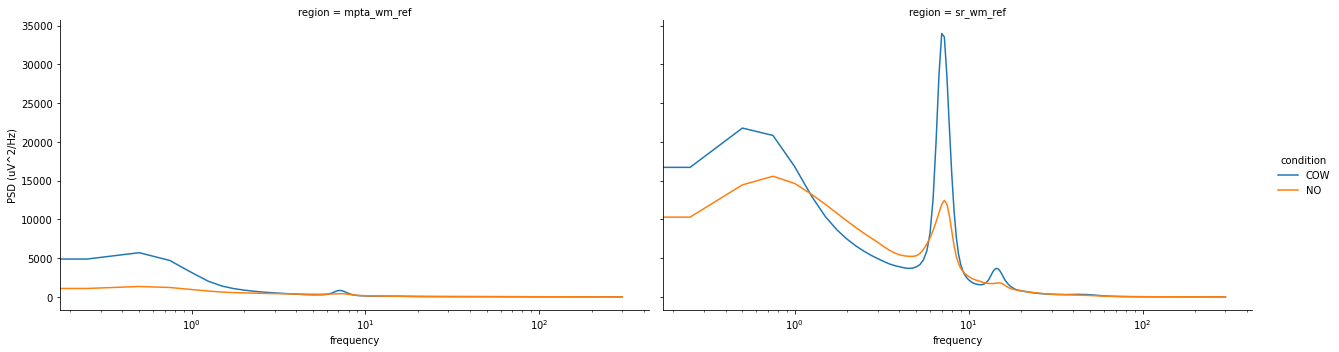

In [24]:
g = sns.relplot(data=smooth_spg(nrem_spg, 1), x='frequency', y='power', hue='condition', col='region', kind='line', aspect=(16/9), ci=None)
g.set(xscale='log', yscale='linear', ylabel='PSD (uV^2/Hz)')
g.tight_layout()

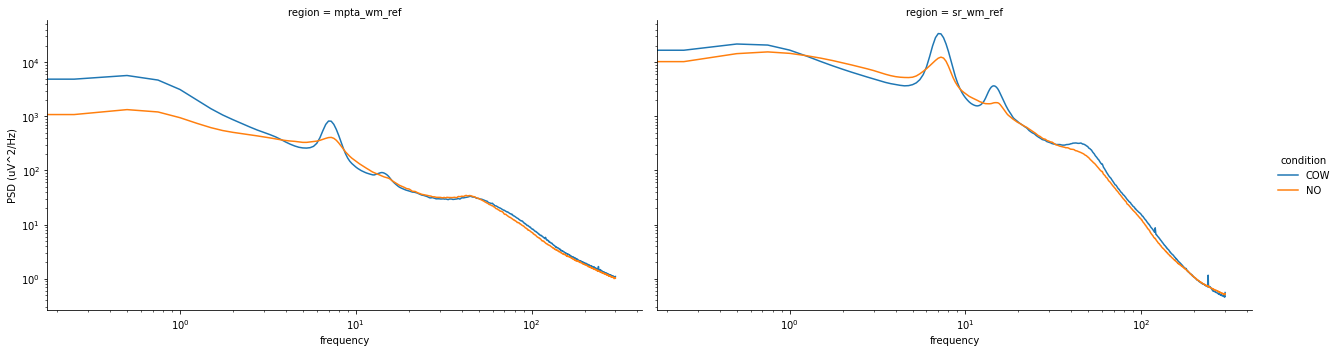

In [25]:
g = sns.relplot(data=smooth_spg(nrem_spg, 1), x='frequency', y='power', hue='condition', col='region', kind='line', aspect=(16/9), ci=None)
g.set(xscale='log', yscale='log', ylabel='PSD (uV^2/Hz)')
g.tight_layout()

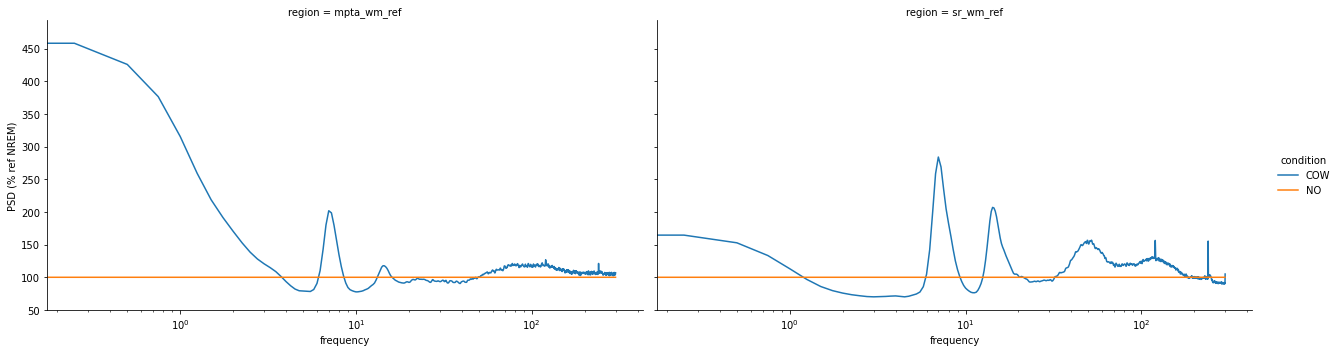

In [26]:
g = sns.relplot(data=smooth_spg(nrem_prm, 1), x='frequency', y='power', hue='condition', col='region', kind='line', aspect=(16/9), ci=None)
g.set(xscale='log', ylabel='PSD (% ref NREM)')
g.tight_layout()